In [1]:
%load_ext autoreload
#%reload_ext autoreload

%autoreload 2

import numpy as np
import os

import os

os.environ["CUDA_VISIBLE_DEVICES"]='0'




In [2]:

from tensorflow.keras.datasets import mnist

In [3]:
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [5]:
from gtda.images import RadialFiltration,Binarizer
from gtda.homology import CubicalPersistence

binarizer=Binarizer()
radial=RadialFiltration()
cub=CubicalPersistence()
radial=radial.fit(x_train)
binarizer=binarizer.fit(x_train)
cub=cub.fit(x_train)
def preprocess(x):
    persistance=cub.transform(radial.transform(binarizer.transform(x)))
    mask=(persistance[:,:,0]-persistance[:,:,1])==np.zeros_like(persistance[:,:,0])
    z=persistance.copy()
    z[mask]=0
    x=(np.split(z,indices_or_sections=z.shape[1],axis=1))
    x=[_x.squeeze() for _x in x]

    return x

def preprocess_2(x):
    persistance=cub.transform(radial.transform(x))
    mask=(persistance[:,:,0]-persistance[:,:,1])==np.zeros_like(persistance[:,:,0])
    z=persistance.copy()
    z[mask]=0
    x=(np.split(z,indices_or_sections=z.shape[1],axis=1))
    x=[_x.squeeze() for _x in x]

    return x


In [6]:
x_post_1=preprocess(np.concatenate([x_train,x_test],axis=0))
x_post_2=preprocess_2(np.concatenate([x_train,x_test],axis=0))

In [8]:
x_post=[x_post_1,x_post_2]

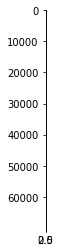

In [9]:
import matplotlib.pyplot as plt

plt.imshow(x_post_1[0])

In [14]:
from tensorflow.keras import layers
import tensorflow as tf
import math as m




In [15]:

class Gaussian(layers.Layer):

    def __init__(self, h=2):
        super(Gaussian, self).__init__()
        init=tf.random_uniform_initializer()
        
        self.m1=tf.Variable(shape=(h,),initial_value=init(shape=(h,)))
        self.v1=tf.Variable(shape=(h,),initial_value=init(shape=(h,)))
        
        self.m2=tf.Variable(shape=(h,),initial_value=init(shape=(h,)))
        
        self.v2=tf.Variable(shape=(h,),initial_value=init(shape=(h,)))
        
        self.a=tf.Variable(shape=(h,),initial_value=init(shape=(h,)))
        
        #self.var=tf.Variable(shape=(n,),initial_value=init(shape=(n,)))
        #self.mean=[tf.keras.layers.Dense(n,activation=None) for _ in range(m)]
        #self.logvar=[tf.keras.layers.Dense(n,activation=None) for _ in range(m)]
            
    def call(self, inputs):
        h=tf.cast(inputs[:,:,2],dtype=tf.int32)
        #tf.print(h.shape)
        m1=tf.gather(self.m1,h)
        v1=tf.gather(self.v1,h)
        x1=inputs[:,:,0]
        
        m2=tf.gather(self.m2,h)
        v2=tf.gather(self.v2,h)
        x2=inputs[:,:,1]
        
        a=tf.gather(self.a,h)
        
        return a*tf.exp(-((x1-m1)**2/(2*v1**2)+(x2-m2)**2/(2*v2**2)))

In [16]:
gs

[]

In [17]:
gs=[]
inputs=[]
for _x_post in x_post:
    x_stack=tf.stack(_x_post,axis=1)
    max_h=tf.reduce_max(x_stack[:,:,2])
    g=Gaussian(h=tf.cast((max_h+1),dtype=tf.int64))
    

    _inputs=[tf.keras.Input(shape=(3,)) for _ in range(len(_x_post))]
    
    inputs+=_inputs
    gs.append(tf.reduce_sum(g(tf.stack(_inputs,axis=1)),axis=-1))
#print(tf.concat(gs,axis=1))
gaussians=tf.stack(gs,axis=1)#tf.reduce_sum(gs,axis=-1)
logits=tf.keras.layers.Dense(50,activation="relu")(gaussians)
logits=tf.keras.layers.Dense(30,activation="relu")(logits)
logits=tf.keras.layers.Dense(20,activation="relu")(logits)
logits=tf.keras.layers.Dense(10,activation=None)(logits)


In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [ ]:
from tensorflow.keras.models import Model
model=Model(inputs=inputs,outputs=logits)

In [ ]:
model.compile(optimizer='adam',loss=loss_fn,metrics=['accuracy'])

In [19]:
x_train_post=[]
x_test_post=[]
for _x_post in x_post:
    x_train_post+=[_x[:60000] for _x in _x_post]
    
    x_test_post+=[_x[60000:] for _x in _x_post]
#x_train_post=np.transpose(np.array(x_train_post),[1,0,2])
#x_test_post=np.transpose(np.array(x_test_post),[1,0,2])

In [ ]:
model.fit(x_train_post,y_train,batch_size=batch_size,epochs=10)

In [ ]:
model.evaluate(x_test_post,y_test)

(None, 3)
